In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *
from ipywidgets import interact

F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
Trans = lambda x: 10**(-0.2*x/10)
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

In [2]:
def T_avg_one_repeater(L1,L2,Nmax=10000):
    τ1 = L1/c
    τ2 = L2/c
    p1 = p_link*Trans(L1)
    p2 = p_link*Trans(L2)
    N1 = F_geo(np.random.rand(Nmax),p1)
    N2 = F_geo(np.random.rand(Nmax),p2)
    Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0)
    T_tot = τ1 + np.mean(Ts)
    f_memory = np.mean(np.exp(-(4*Ts-(4*N1-5)*τ1-(4*N2-3)*τ2)/τ_coh))
    f_memory_qkd = np.mean(np.exp(-(2*Ts-(2*N1-1)*τ1-(2*N2-2)*τ2)/τ_coh))
    return T_tot, f_memory, f_memory_qkd

def T_avg_mc_n_rep(links, cct= False,Nmax=10000):
    N_links = len(links)
    τs = links/c
    Ns = np.zeros((N_links,Nmax))
    Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
    for i in range(1,N_links):
        Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
    
    Ts = np.zeros((N_links-1,Nmax))
    Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
    for i in range(1,N_links-1):
        Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
    f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
    if cct: # inclduing classical comm. 
        Tsw = np.zeros((N_links-1,Nmax))
        Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
        for i in range(1,N_links-1):
            Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
            
        T_tot = np.mean(np.max(Tsw,axis=0))           
        Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    else:
        T_tot = np.mean(np.max(Ns,axis=0))
        Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] #np.zeros((1,Nmax))
        Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] #np.zeros((1,Nmax))
        f_memory = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))

    return T_tot, f_memory, f_memory_qkd


# One repeater

# Sequential
## Rate vs. Distance

In [3]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1
τ_cut = 0.1*τ_coh # cutoff

L0_list = np.linspace(10,800,101) # e2e distance [km]
inv_rate_seq = np.zeros(len(L0_list))
f_memory_seq = np.zeros(len(L0_list))
f_memory_qkd_seq = np.zeros(len(L0_list))
inv_rate_seq_cutoff = np.zeros(len(L0_list))
f_memory_seq_cutoff = np.zeros(len(L0_list))
f_memory_qkd_seq_cutoff = np.zeros(len(L0_list))

for i, L0 in enumerate(L0_list):
    L1 = L0/2
    L2 = L0/2
    inv_rate_seq[i] = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
    f_memory_qkd_seq[i] = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )
    p1 = p_link*Trans(L1)
    q1= 1-p1 
    τ1 = L1/c
    m = int(τ_cut/(2*τ1))
    P = 1-q1**m
    n_avg = (-m*q1**m*p1+(1-q1**m))/p1
    inv_rate_seq_cutoff[i] = 2*τ1/(p1*P)+ ((1/P-1)*m+n_avg)*2*τ1
    f_memory_qkd_seq_cutoff[i] = p1*np.exp(-4*τ1/τ_coh)*(1- (q1*np.exp(-2*τ1/τ_coh))**m )/(1- q1*np.exp(-2*τ1/τ_coh) )/(1- q1**m)


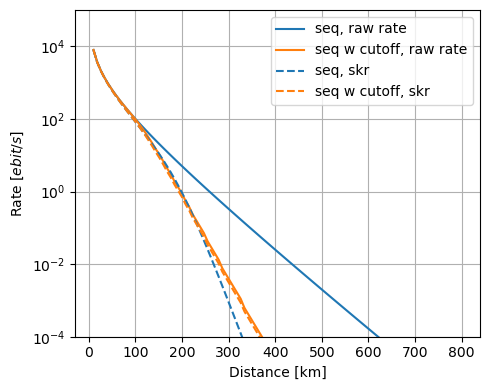

In [4]:
f_qkd_seq = 0.5-0.5*f_memory_qkd_seq
f_qkd_seq_cutoff = 0.5-0.5*f_memory_qkd_seq_cutoff
plt.figure(figsize=(5,4))
# plt.plot(L0_list,-np.log2(1-Trans(L0_list)),"k--", label="PLOB")
plt.plot(L0_list,1/inv_rate_seq,"-",color="C0", label="seq, raw rate")
plt.plot(L0_list,1/inv_rate_seq_cutoff,"-",color="C1", label="seq w cutoff, raw rate")
plt.plot(L0_list,(1-h(f_qkd_seq))/inv_rate_seq,"--",color="C0", label="seq, skr")
plt.plot(L0_list,(1-h(f_qkd_seq_cutoff))/inv_rate_seq_cutoff,"--",color="C1", label="seq w cutoff, skr")
plt.yscale("log")
plt.xlabel("Distance [km]")
plt.ylabel(r"Rate $[ebit/s]$")
plt.ylim([1e-4,1e5])
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
plt.show()



## Rate vs. cut-off

In [7]:
c = 2e5 # speed of light [km/s]
τ_coh = 0.1
p_link= 1

def rate_vs_cutoff(L0=130):
# L0 = 200 # e2e distance [km]
    τ_list = np.linspace(0.1,1,50)*τ_coh # cutoff
    L1 = L0/2
    L2 = L0/2
    p1 = p_link*Trans(L1)
    q1= 1-p1 

    inv_rate_seq = 2*L1/(c* p_link*Trans(L1))+2*L2/(c* p_link*Trans(L2))
    f_memory_qkd_seq = p_link*Trans(L2)*np.exp(-4*L2/(c*τ_coh))/(1- (1-p_link*Trans(L2))*np.exp(-2*L2/(c*τ_coh)) )

    inv_rate_seq_cutoff = np.zeros(len(τ_list))
    f_memory_qkd_seq_cutoff = np.zeros(len(τ_list))

    for i, τ_cut in enumerate(τ_list):
        τ1 = L1/c
        m = int(τ_cut/(2*τ1))
        P = 1-q1**m
        n_avg = (-m*q1**m*p1+(1-q1**m))/p1
        inv_rate_seq_cutoff[i] = 2*τ1/(p1*P)+ ((1/P-1)*m+n_avg)*2*τ1
        f_memory_qkd_seq_cutoff[i] = p1*np.exp(-4*τ1/τ_coh)*(1- (q1*np.exp(-2*τ1/τ_coh))**m )/(1- q1*np.exp(-2*τ1/τ_coh) )/(1- q1**m)

    f_qkd_seq = [0.5-0.5*f_memory_qkd_seq]
    f_qkd_seq_cutoff = 0.5-0.5*f_memory_qkd_seq_cutoff
    plt.figure(figsize=(5,4))
    plt.plot(1e3*τ_list,τ_list*0+1/inv_rate_seq,"-",color="C0", label="seq, raw rate")
    plt.plot(1e3*τ_list,1/inv_rate_seq_cutoff,"-",color="C1", label="seq w cutoff, raw rate")
    plt.plot(1e3*τ_list,τ_list*0+(1-h(f_qkd_seq))/inv_rate_seq,"--",color="C0", label="seq, skr")
    plt.plot(1e3*τ_list,(1-h(f_qkd_seq_cutoff))/inv_rate_seq_cutoff,"--",color="C1", label="seq w cutoff, skr")
#     plt.yscale("log")
    plt.xlabel("cut-off [ms]")
    plt.ylabel(r"Rate $[ebit/s]$")
    # plt.ylim([1e-4,1e5])
    plt.grid()
    plt.legend()
    plt.tight_layout()
    # plt.savefig("figures_realtime/one_repeater_no_cutoff.pdf")
    plt.show()

In [8]:
interact(rate_vs_cutoff, L0=(50, 200,10));

interactive(children=(IntSlider(value=130, description='L0', max=200, min=50, step=10), Output()), _dom_classe…